In [1]:
import os
import copy
import torch
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from scipy.linalg import orthogonal_procrustes

from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from helper import concat_nback_decoder_data_gen, nback_decoder_cnn_data_gen, nback_decoder_data_gen
from decoding_helper import task_index_gen, read_data, dec2bin, nback_bin_task_index_mapper, find_nback_task_rule, get_nback_slice_data

save_path = "/home/xiaoxuan/projects/multfs_triple/evaluation/Organized_analysis/results/across_time_rotation_decoding"
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    
    
import matplotlib as mpl 
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})
sns.set_context("poster")
mpl.rcParams['axes.linewidth']=2.5
mpl.rcParams['ytick.major.width']=2.5
mpl.rcParams['xtick.major.width']=2.5
    
colors = [(105/256,103/256,149/256),(114/256,188/256,213/256),(255/256,208/256,111/256),(231/256,98/256,84/256)]
bg_colors = [(55/256,103/256,149/256), (170/256,220/256,224/256),(255/256,230/256,183/256),(239/256,138/256,71/256)]
# feature_list = ["location", "identity", "category"]

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def decoder(data, label, return_weight_vector=True):
    # Grid search to find the best C value
    param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.07,  0.1, 0.5, 1, 5, 10]}  # Adjust the values as needed
    grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5)
    grid_search.fit(data, label)
    best_C = grid_search.best_params_['C']
    print("Best C:", best_C)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.1)
    
    # Train SVC classifier with best C value
    clf = make_pipeline(StandardScaler(), SVC(kernel="linear", gamma='auto', C=best_C))
    clf.fit(X_train, y_train)
    
    # Predictions
    y_pred = clf.predict(X_test)
    
    # Get the weight vector and intercept
    weight_vector = clf.named_steps['svc'].coef_
    intercept = clf.named_steps['svc'].intercept_

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    
    if not return_weight_vector:
        return clf.named_steps["svc"], accuracy, X_train, y_train, X_test, y_test
    else:
        return clf.named_steps["svc"], weight_vector, accuracy, X_train, y_train, X_test, y_test

def frame_based_corrected_trials(df, frame_check = [1], is_balanced = True):
    "input dataframe with pre-selected single n_back task (fixed_n)"
    "return trials with corrected trials for frames in frame_check, if is_balanced is True, subsample to the smallest trials of all tasks"
    curr_df = df
    selected_trials = [i for i in range(len(curr_df)) if (curr_df.predicted_action.iloc[i][frame_check] == curr_df.corrected_action.iloc[i][frame_check]).all()]
    curr_df = curr_df.iloc[selected_trials]
    
    return curr_df

In [3]:
class CustomLinearSVC:
    def __init__(self, w, b, label_1, label_2,X_train):
        self.w = w
        self.b = b
        self.label_1 = label_1
        self.label_2 = label_2
        self.scaler = StandardScaler()
        self.scaler.fit(X_train)

    def predict(self, X):
        # Calculate the decision boundary values for a set of data points X
        X = self.scaler.transform(X)
       
        decision_values = np.dot(X, self.w) + self.b
#         clf = make_pipeline(StandardScaler(), SVC(kernel="linear", gamma='auto', C=best_C))
        predicted_labels = np.where(decision_values > 0, self.label_1, self.label_2)
        return predicted_labels

In [4]:
def scale_matrice(matrix):
    min_value = np.min(matrix)
    max_value = np.max(matrix)

    # Apply Min-Max scaling to each matrix in the list
    scaled_matrix = (matrix - min_value) / (max_value - min_value)
    return scaled_matrix

def std_matrix(data1):
    mtx1 = np.array(data1, dtype=np.double, copy=True)
    
    if mtx1.ndim != 2:
        raise ValueError("Input matrices must be two-dimensional")
    if mtx1.size == 0:
        raise ValueError("Input matrices must be >0 rows and >0 cols")

    # translate all the data to the origin
    trans_mtx = np.mean(mtx1, 0)
    mtx1 -= trans_mtx

    norm1 = np.linalg.norm(mtx1)

    if norm1 == 0:
        raise ValueError("Input matrices must contain >1 unique points")

    # change scaling of data (in rows) such that trace(mtx*mtx') = 1
    mtx1 /= norm1
    return mtx1, norm1, trans_mtx # org_mtx = mtx * norm1 + trans_mtx

def procrustes(mtx1, mtx2):
    # data are after std_matrix
    # transform mtx2 to minimize disparity
    R, s = orthogonal_procrustes(mtx1, mtx2)
    mtx2 = np.dot(mtx2, R.T) * s

    # measure the dissimilarity between the two datasets
    disparity = np.sum(np.square(mtx1 - mtx2))

    return mtx1, mtx2, disparity, R, s

# Obtain cross time binary decoding hyperplane for memory space

In [5]:
basepath_list = [
    # change the path to the correct one
    "/mnt/store1/xiaoxuan/multfs_triple/eval/experiment_logs/2024515/95722_rep0_844" # 9tasks RNN size 512
        
                ] # (nback multifeature rnn model)

In [6]:
def get_nback_slice_data(df, nback_n, t_activation, t_label, is_hidden = None):
    
    df = df[df["ntask_index"] == nback_n]
    if t_label + nback_n < 6:
        df = frame_based_corrected_trials(df, frame_check = [t_label+nback_n], is_balanced = True)
    

    df = df.sample(frac=1)
    if is_hidden == True:
        RNN_activation = np.stack(df.hidden_state.to_numpy())[:,t_activation,:]
    elif is_hidden == False:
        RNN_activation = np.stack(df.cell_state.to_numpy())[:,t_activation,:]
    else:
        RNN_activation = np.stack(df.activation.to_numpy())[:,t_activation,:]
    try:
        CNN_activation = np.stack(df.CNN_activation_2.to_numpy())[:,t_activation,:,:,:].reshape(-1, 256*7*7)
    except: CNN_activation = np.zeros_like(RNN_activation)

    ntask_index = df.ntask_index.to_numpy()
    feature_index = df.feature_index.to_numpy()
    loc_label = np.squeeze(np.stack(df.input_loc.to_numpy())[:,t_label])
    obj_label = np.squeeze(np.stack(df.input_obj.to_numpy())[:,t_label])
    ctg_label = np.squeeze(np.stack(df.input_ctg.to_numpy())[:,t_label])
    
    # sorted according to feature_index and normalize the activation vector
    sorted_indices = np.argsort(feature_index)
    feature_index = feature_index[sorted_indices]
    RNN_activation = RNN_activation[sorted_indices]
    starting_indice = 0
    for fi in set(feature_index):
        l = np.sum(feature_index == fi)
        RNN_activation[starting_indice:l+starting_indice] = RNN_activation[starting_indice:l+starting_indice] - np.mean(RNN_activation[starting_indice:l+starting_indice], axis = 0)
        starting_indice += l
    CNN_activation = CNN_activation[sorted_indices]
    ntask_index = ntask_index[sorted_indices]
    loc_label = loc_label[sorted_indices]
    obj_label = obj_label[sorted_indices]
    ctg_label = ctg_label[sorted_indices]
    return RNN_activation, CNN_activation, ntask_index, feature_index, loc_label, obj_label, ctg_label


In [7]:
# iterate over all pickle files and collect all possible nback ns and feature index
feature_nback_mapping = {}

# Iterate over files in the directory
for filename in os.listdir(basepath_list[0]):
    # Check if the filename matches the pattern
    if filename.endswith("_activations.csv"):
        # Parse the nback and feature indices from the filename
        parts = filename.split("_")
        nback_index = int(parts[0].replace("back", ""))
        feature_index = int(parts[2].replace("feature", ""))
        
        # Update the dictionary
        if feature_index not in feature_nback_mapping:
            feature_nback_mapping[feature_index] = set()
        feature_nback_mapping[feature_index].add(nback_index)

print("Feature-Nback Mapping:")
for feature_index, nback_indices in feature_nback_mapping.items():
    print("Feature", feature_index, ": Possible nback indices:", nback_indices)


Feature-Nback Mapping:
Feature 2 : Possible nback indices: {1, 2, 3}
Feature 1 : Possible nback indices: {1, 2, 3}
Feature 0 : Possible nback indices: {1, 2, 3}


In [8]:
mode = "val_angle"

In [9]:
acc_across_features = {}
hyperplanes_features = {}
biases_features = {}
Rs_features = {}
transformed_accs_across_features = {}

In [10]:
# goal: obtain all decoder hyperplanes, including perceptual, memory and post-executive steps
# specify which featuer to look at
# only consider location for now
feature_list = [1]

# for 1back task: decoding w.r.t specific tasks => only for generalization decoding accuracy
# reminder!!! this cell does not account for transformation accuracy evalution with n_feature_values * n_dim_hyperplane
nback_n = 3
seq_len = 6
n0_bootstraps = 1
n_bootstraps = 2 # random split of train/val for training the decoder
n_feature_values = [4,8,4]

X_trains = {}
y_trains = {}
X_tests = {}
y_tests = {}

for task_feature in feature_list: 
    decoding_feature = task_feature
    # obtain the task relevant data
    task_name, df = read_data(basepath_list[0], path2file = basepath_list[0] + "/%dback_feature_%d_activations.pkl" % (nback_n, task_feature), mode = mode)

    # get the label data
    _,_,_,_, loc_label, obj_label, ctg_label = get_nback_slice_data(df, 3, 0, 0)

    if task_feature == 1:
        n_feature_value = len(np.unique(obj_label))
    elif task_feature == 0:
        n_feature_value = len(np.unique(loc_label))
    elif task_feature == 2:
        n_feature_value = len(np.unique(ctg_label))
    
    network_size = df.activation[0].shape[-1]
    hyperplanes = np.zeros((seq_len - nback_n, n_feature_value, seq_len, n_bootstraps, network_size, n0_bootstraps))
    biases = np.zeros((seq_len - nback_n, n_feature_value, seq_len, n_bootstraps, n0_bootstraps))
    # validation accuracy of transformed decoding hyperplane
    accs_across_time = np.zeros((seq_len - nback_n, n_feature_value, seq_len, n_bootstraps, n0_bootstraps))
    
    
    for n0b in range(n0_bootstraps):
        for t_label in range(seq_len - nback_n):
            print("-----------------------------------------------------")
            for t_activation in range(t_label, seq_len):
               
                # train decoding on perceptual space, test on memory space
                RNN_activation_A, CNN_activation_A, ntask_index_A, feature_index_A, loc_label_A, obj_label_A, ctg_label_A = get_nback_slice_data(df, nback_n, t_activation, t_label, is_hidden = None)

                RNN_activation = RNN_activation_A
                CNN_activation = CNN_activation_A
                ntask_index = ntask_index_A
                feature_index = feature_index_A
                loc_label = loc_label_A
                obj_label = obj_label_A
                ctg_label = ctg_label_A
        
                subsample_indices = np.where(feature_index == task_feature)[0]
                RNN_activation = RNN_activation[subsample_indices]
                data = RNN_activation
                labels = [loc_label, obj_label, ctg_label]
                label = labels[decoding_feature]
                label = label[subsample_indices]
                
                curr_feature_value_list = np.unique(label)


                # train 1 vs n-1 binary decoder: 
                # step 1: obtain the data
                for f1_index, f1 in enumerate(curr_feature_value_list):
                    
                    replace_indice = np.where(label != f1)[0]
                    curr_data = copy.deepcopy(data)
                    curr_label = copy.deepcopy(label)
                    curr_label[replace_indice] = 1000

                    # subsample the same number of 0/1 cases
                    subsample_len = len(np.where(label == f1)[0])
                    np.random.shuffle(replace_indice)
                    selected_indice = np.stack([np.where(curr_label == f1)[0], replace_indice[:subsample_len]]).reshape(-1)
                    curr_data = curr_data[selected_indice]
                    curr_label = curr_label[selected_indice]

                    print("t_activation: %d, t_label: %d" %(t_activation, t_label))
                    bi = 0
                    while bi < n_bootstraps:
                    
                        clf, weight_vector, accuracy, X_train, y_train, X_test, y_test = decoder(curr_data, curr_label, return_weight_vector = True)
                        
                        X_tests["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature,t_label, t_activation, f1,bi,n0b)] = X_test
                        y_tests["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature,t_label, t_activation, f1,bi,n0b)] = y_test
                        X_trains["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature,t_label, t_activation, f1,bi,n0b)] = X_train
                        y_trains["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature,t_label, t_activation, f1,bi,n0b)] = y_train

#                         hyperplanes[t_label, f1_index,t_activation, bi, :, n0b] = weight_vector

                        hyperplanes[t_label, f1_index,t_activation, bi, :, n0b] = clf.coef_
    #                         bias = clf.intercept_[0]
                        bias = clf.intercept_
                        biases[t_label, f1_index,t_activation, bi, n0b] = bias
                        # sanity check: guarantee we always have good enough decoder if feature information exist
                        print("what is the accuracy here:", accuracy)
                        if t_activation < t_label + nback_n -1:
                            if accuracy >= 0.85:
                                print("the accuracy passed the threshold")
                                
                                # sanity check: if the svc reconstruction object works

                                trans_clf = CustomLinearSVC(weight_vector.T, bias, label_1=1000, label_2 = f1, X_train = X_train)


                                predicted_label = trans_clf.predict(X_test)
        
                                updated_accuracy = accuracy_score(y_test, predicted_label)
                                print("accuracy after the svc reconstruction from the weight vector and the biase:", updated_accuracy)
                                if updated_accuracy - accuracy > 0.1:
                                    print("-------------------reconstructed svc failed!-----------------")
                                    continue
                                else:
                                    accs_across_time[t_label, f1_index,t_activation, bi, n0b] = accuracy
                                    bi += 1
                            else: 
                                print("not good enough accuracy")
                                print("what is bi:", bi)
                                continue
                        else: 
                            accs_across_time[t_label, f1_index,t_activation, bi, n0b] = accuracy
    
                            # sanity check: if the svc reconstruction object works

                            trans_clf = CustomLinearSVC(weight_vector.T, bias, label_1=1000, label_2 = f1, X_train = X_train)


                            predicted_label = trans_clf.predict(X_test)
    #                         print(predicted_label)
                            updated_accuracy = accuracy_score(y_test, predicted_label)
                            print("accuracy after the svc reconstruction from the weight vector and the biase:", updated_accuracy)
                            if updated_accuracy - accuracy > 0.1:
                                print("-------------------reconstructed svc failed!-----------------")
                                continue
                            else:
                                accs_across_time[t_label, f1_index,t_activation, bi, n0b] = accuracy
                                bi += 1
                        
                        
    acc_across_features["tf%d_df%d"%(task_feature, decoding_feature)] = accs_across_time
    hyperplanes_features["tf%d_df%d"%(task_feature, decoding_feature)] = hyperplanes
    biases_features["tf%d_df%d"%(task_feature, decoding_feature)] = biases
    
        
    

-----------------------------------------------------
t_activation: 0, t_label: 0
Best C: 0.01
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
Best C: 0.01
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
t_activation: 0, t_label: 0
Best C: 0.01
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
Best C: 0.01
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
t_activation: 0, t_label: 0
Best C: 0.01
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1

Best C: 0.07
Accuracy: 0.96
what is the accuracy here: 0.9555555555555556
accuracy after the svc reconstruction from the weight vector and the biase: 0.9555555555555556
Best C: 0.07
Accuracy: 1.00
what is the accuracy here: 1.0
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
t_activation: 3, t_label: 0
Best C: 0.05
Accuracy: 1.00
what is the accuracy here: 1.0
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
Best C: 0.05
Accuracy: 0.95
what is the accuracy here: 0.9523809523809523
accuracy after the svc reconstruction from the weight vector and the biase: 0.9523809523809523
t_activation: 3, t_label: 0
Best C: 0.01
Accuracy: 1.00
what is the accuracy here: 1.0
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
Best C: 0.01
Accuracy: 0.97
what is the accuracy here: 0.9722222222222222
accuracy after the svc reconstruction from the weight vector and the biase: 0.9722222222222222
t_activation: 3, t_l

Best C: 0.1
Accuracy: 0.73
what is the accuracy here: 0.7333333333333333
accuracy after the svc reconstruction from the weight vector and the biase: 0.7333333333333333
t_activation: 5, t_label: 0
Best C: 0.1
Accuracy: 0.80
what is the accuracy here: 0.8
accuracy after the svc reconstruction from the weight vector and the biase: 0.8
Best C: 0.1
Accuracy: 0.73
what is the accuracy here: 0.7333333333333333
accuracy after the svc reconstruction from the weight vector and the biase: 0.7333333333333333
-----------------------------------------------------
t_activation: 1, t_label: 1
Best C: 0.05
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
Best C: 0.05
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
t_activation: 1, t_label: 1
Best C: 0.05
Accuracy: 1.00
what is the ac

Best C: 0.1
Accuracy: 0.93
what is the accuracy here: 0.925
accuracy after the svc reconstruction from the weight vector and the biase: 0.925
t_activation: 3, t_label: 1
Best C: 0.05
Accuracy: 0.90
what is the accuracy here: 0.9047619047619048
accuracy after the svc reconstruction from the weight vector and the biase: 0.9047619047619048
Best C: 0.05
Accuracy: 0.95
what is the accuracy here: 0.9523809523809523
accuracy after the svc reconstruction from the weight vector and the biase: 0.9523809523809523
t_activation: 3, t_label: 1
Best C: 0.05
Accuracy: 0.91
what is the accuracy here: 0.9090909090909091
accuracy after the svc reconstruction from the weight vector and the biase: 0.9090909090909091
Best C: 0.05
Accuracy: 0.91
what is the accuracy here: 0.9090909090909091
accuracy after the svc reconstruction from the weight vector and the biase: 0.9090909090909091
t_activation: 3, t_label: 1
Best C: 0.05
Accuracy: 0.96
what is the accuracy here: 0.9565217391304348
accuracy after the svc r

Best C: 0.01
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
t_activation: 2, t_label: 2
Best C: 0.01
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
Best C: 0.01
Accuracy: 0.98
what is the accuracy here: 0.975609756097561
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 0.975609756097561
t_activation: 2, t_label: 2
Best C: 0.05
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
Best C: 0.05
Accuracy: 1.00
what is the accuracy here: 1.0
the accuracy passed the threshold
accuracy after the svc reconstruction from the weight vector and the biase: 1.0
t_activation: 2, t_label: 2
Best C: 0.05
Accuracy: 

Best C: 0.01
Accuracy: 0.93
what is the accuracy here: 0.926829268292683
accuracy after the svc reconstruction from the weight vector and the biase: 0.926829268292683
t_activation: 5, t_label: 2
Best C: 0.05
Accuracy: 0.97
what is the accuracy here: 0.975
accuracy after the svc reconstruction from the weight vector and the biase: 0.975
Best C: 0.05
Accuracy: 0.93
what is the accuracy here: 0.925
accuracy after the svc reconstruction from the weight vector and the biase: 0.925
t_activation: 5, t_label: 2
Best C: 0.01
Accuracy: 0.91
what is the accuracy here: 0.9069767441860465
accuracy after the svc reconstruction from the weight vector and the biase: 0.9069767441860465
Best C: 0.01
Accuracy: 0.91
what is the accuracy here: 0.9069767441860465
accuracy after the svc reconstruction from the weight vector and the biase: 0.9069767441860465
t_activation: 5, t_label: 2
Best C: 0.5
Accuracy: 0.90
what is the accuracy here: 0.9024390243902439
accuracy after the svc reconstruction from the weigh

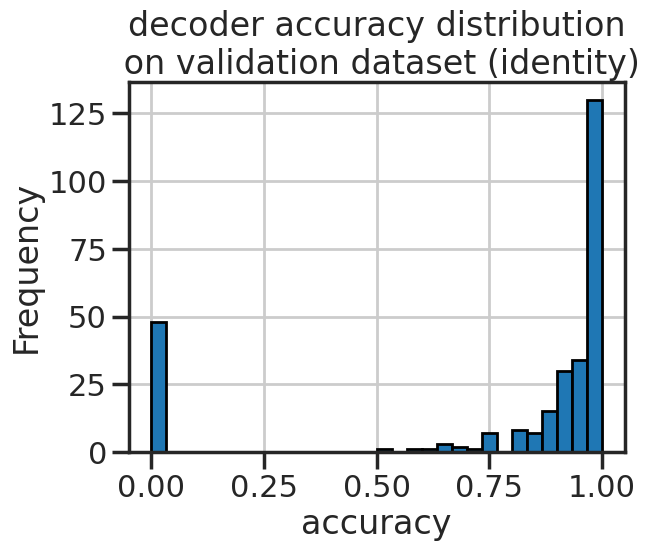

In [11]:
# sanity check: if the decoder's performance on validatio dataset is good enough
plt.hist(accs_across_time.reshape(-1), bins=30, edgecolor='black')  # Adjust the number of bins as needed
if task_feature == 0:
    feature_name = "location"
elif task_feature == 1:
    feature_name = "identity"
elif task_feature == 2:
    feature_name = "category"
plt.title('decoder accuracy distribution\n on validation dataset (%s)' % feature_name)
plt.xlabel('accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# it is reasonable to see all those zeros, since we do not train decoders to using activation to predict future label. 
# the only thing matters is where it has been filled with real accuracy 
# the drop in performance also makes sense, since it always happen after the executive timestep

In [12]:
# # sanity check: - Can we identify the rotation matrix between two vectors 
# # orthogonal to each other of shape 256 with procrustes test? 

# # generate 2 matrix that are almost identical to each other
# # Generate a random binary matrix of shape (1, 256)
# # matrix_1 = np.ones((2, 256))
# # matrix_1[1,:] = matrix_1[0,:] * 2 + np.random.normal(loc=0, scale=0.01, size=(256))
# # matrix_2 = matrix_1 + np.random.normal(loc=0, scale=0.01, size=(2, 256,))

# # Define the given vector
# matrix_1 = np.array([[1, 0, 0], [1.001, 0, 0], [1.0001, 0, 0]])
# matrix_2 = np.array([[0, 1.01, 0], [0, 1, 0], [0, 1.0001, 0]])

# # # Check the dot product with the given vector
# # dot_product = np.dot(matrix_1, matrix_2.T)
# # print("Dot product with the given vector:")
# # print(dot_product)

# a, norm_a, trans_mtx_a = std_matrix(matrix_1)
# b, norm_b, trans_mtx_b = std_matrix(matrix_2)
# mtx1, mtx2, disparity, R, s = procrustes(b, a)

# print(disparity)
# print(R.shape)

# # the problem with scipy.spatial.procrustes is that it does not return the rotation matrix => need to go back to the code
# # for first of all, check the disparity level
# # mtx1, mtx2, disparity = procrustes(a, b)

In [13]:
# from scipy.spatial.transform import Rotation

# # Example rotation matrix
# rotation_matrix = R
# # Check if the matrix is a valid rotation matrix
# if np.allclose(np.dot(rotation_matrix, rotation_matrix.T), np.eye(3)) and np.isclose(np.abs(np.linalg.det(rotation_matrix)), 1.0):
#     # Convert the rotation matrix to a rotation object
#     rotation = Rotation.from_matrix(rotation_matrix)

#     # Convert the rotation to axis-angle representation
#     rotvec = rotation.as_rotvec()

#     # Extract the rotation angle from the rotation vector
#     angle = np.linalg.norm(rotvec)

#     # Print the rotation angle in degrees
#     print("Rotation angle (degrees):", np.degrees(angle))
# else:
#     print("Invalid rotation matrix!")

In [14]:
# plt.imshow(R)
# plt.title("visualization of the Rotation matrix")
# plt.colorbar()

In [15]:
# print(n0_bootstraps)

In [16]:
# # updated goal: for each feature value, test if the procrustes analysis captures the rotation accuracte between consecutive timesteps
# for task_feature in feature_list:
#     if task_feature == 1:
#         n_feature_value = len(np.unique(obj_label))
#     elif task_feature == 0:
#         n_feature_value = len(np.unique(loc_label))
#     elif task_feature == 2:
#         n_feature_value = len(np.unique(ctg_label))
#     print(task_feature)
#     transformed_accs_across_time = np.zeros((seq_len-nback_n, n_feature_value, seq_len,n0_bootstraps))
#     disparities = np.zeros((seq_len - nback_n, seq_len, n_feature_value, n0_bootstraps))
#     Rs = np.zeros((seq_len-nback_n, seq_len, 256, 256,  n_feature_value, n0_bootstraps))
# #     Rs = np.zeros((seq_len-nback_n, seq_len, 512, 512,  n_bootstraps, n0_bootstraps))
    
#     for n0b in range(n0_bootstraps):
        
#         for t_label in range(seq_len - nback_n):
#             for si in range(t_label, seq_len - 1):
#                 sj = si
#                 if task_feature == 1:
#                     curr_feature_value_list = np.unique(obj_label)
#                 else:
#                     curr_feature_value_list = [0,1,2,3]
#                 for f1_index, f1 in enumerate(curr_feature_value_list):
                   

#                     # current timestep decision hyperplane
#                     curr_hyperplane_1 = hyperplanes[t_label, f1_index, si, :,:, n0b]
#                     # next timestep decision hyperplane
#                     curr_hyperplane_2 = hyperplanes[t_label, f1_index, sj, :,:, n0b]
#                     curr_acc_1 = accs_across_time[t_label, f1_index, si, :,n0b]
#                     curr_acc_2 = accs_across_time[t_label, f1_index, sj, :,n0b]
#                     curr_bias_2 = biases[t_label, f1_index, sj, :,n0b]

#                     print(curr_hyperplane_2.shape)
#                     # proctrustes transformation
#                     # with orthgonal procrustes
#                     a, norm_a, trans_mtx_a = std_matrix(curr_hyperplane_1)
#                     b, norm_b, trans_mtx_b = std_matrix(curr_hyperplane_2)
#                     mtx1, mtx2, disparity, R, s = procrustes(b, a)

#                     Rs[t_label, si,:,:,f1_index, n0b] = R # rotation matrix access at si is for tranforming hyperplane from si to si+1

#                     # with scipy.spatial.procrustes
# #                     mtx1, mtx2, disparity = procrustes(curr_hyperplane_2, curr_hyperplane_1)
#                     # mtx2 is the curr_hyperplane_1 that after transformation that best fits for curr_hyperplane_2

                    

#                     print("disparity (difference L2 between transformed and target matrix):", disparity)
#                     disparities[t_label, si, f1_index, n0b] = disparity
#                     # with orthogonal procrustes
#                     # construct the new classifier based on the transformation
#                     hyperplane_2_from_1 = (np.dot(a, R.T) * s)*norm_b + trans_mtx_b
# #                     hyperplane_2_from_1 = np.dot(a, R.T)
                    
# #                     assert np.allclose(mtx2, hyperplane_2_from_1)
# #                     hyperplane_2_from_1 = mtx2 * norm_b + trans_mtx_b
                    
# #                     hyperplane_2_from_1 = np.zeros(mtx2.shape)


#                     # with scipy.spatial.procrustes
# #                     hyperplane_2_from_1 = mtx2
                    
                    
# #                     trans_clf = CustomLinearSVC(hyperplane_2_from_1[0], curr_bias_2[0], label_1=1000, label_2 = f1)
#                     trans_clf = CustomLinearSVC(hyperplane_2_from_1[0], curr_bias_2[0], label_1=1000, label_2 = f1)
                    
#                     curr_data = X_tests["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature,t_label, sj, f1,0,n0b)]
#                     curr_label = y_tests["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature,t_label, sj, f1,0,n0b)]
                    
                    
#                     predicted_label = trans_clf.predict(curr_data)
                    
#                     accuracy = accuracy_score(curr_label, predicted_label)
#                     transformed_accs_across_time[t_label, f1_index,si,n0b] = accuracy
#                     print("accuracy with decoder trained with data:", curr_acc_2[0])
#                     print("accuracy with decoder applied with transformation:", accuracy)
#                     print("difference between the two decoder:", curr_acc_2[0] - accuracy)
#     Rs_features["tf%d_df%d"%(task_feature, decoding_feature)] = Rs
#     transformed_accs_across_features["tf%d_df%d"%(task_feature, decoding_feature)] = transformed_accs_across_time


In [17]:
# print(X_tests.keys())

In [18]:
# # plot the distribution of disparities 
# non_zero_disparities = disparities.reshape(-1)[disparities.reshape(-1) != 0]

# # Plot histogram
# plt.hist(non_zero_disparities, bins=10, color='skyblue', edgecolor='black')

# # Add labels and title
# plt.xlabel('Disparity')
# plt.ylabel('Frequency')
# plt.title('Histogram of Disparities (orthogonal_procrustes)')

# # Show plot
# plt.show()

In [19]:
# # plot the distribution of the normal vectors (hyperplanes)
# # Plot histogram
# plt.hist(hyperplanes.reshape(-1), bins=20, color='blue', alpha=0.7)
# plt.title('Histogram of weights (before normalization)')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

In [20]:
# updated goal: test if the rotation matrix captures for 1 feature value is applicable to another feature value


In [21]:
# goal: if procrustes test is applicable for the decoding hyperplane rotation analysis
for task_feature in feature_list:
    # obtain the task relevant data
    task_name, df = read_data(basepath_list[0], path2file = basepath_list[0] + "/%dback_feature_%d_activations.pkl" % (nback_n, task_feature), mode = mode)

    # get the label data
    _,_,_,_, loc_label, obj_label, ctg_label = get_nback_slice_data(df, 3, 0, 0)
    if task_feature == 1:
        n_feature_value = len(np.unique(obj_label))
    elif task_feature == 0:
        n_feature_value = len(np.unique(loc_label))
    elif task_feature == 2:
        n_feature_value = len(np.unique(ctg_label))
    decoding_feature = task_feature
    transformed_accs_across_time = np.zeros((seq_len-nback_n, n_feature_value, seq_len, n_bootstraps,  n0_bootstraps))
    disparities = np.zeros((seq_len - nback_n, seq_len, n_bootstraps, n0_bootstraps))
    Rs = np.zeros((seq_len-nback_n, seq_len, network_size, network_size,  n_bootstraps, n0_bootstraps))
    scaling_factors = np.zeros((seq_len - nback_n, seq_len, n_bootstraps, n0_bootstraps))
#     Rs = np.zeros((seq_len-nback_n, seq_len, 512, 512,  n_bootstraps, n0_bootstraps))
    
    for n0b in range(n0_bootstraps):
        for b1 in range(n_bootstraps):
            for t_label in range(seq_len - nback_n):
                for si in range(t_label, seq_len - 1):
                    sj = si + 1

                    # current timestep decision hyperplane
                    curr_hyperplane_1 = hyperplanes[t_label, :, si, b1,:, n0b]
                    # next timestep decision hyperplane
                    curr_hyperplane_2 = hyperplanes[t_label, :, sj, b1,:, n0b]
                    curr_acc_1 = accs_across_time[t_label, :, si, b1,n0b]
                    curr_acc_2 = accs_across_time[t_label, :, sj, b1,n0b]
                    curr_bias_2 = biases[t_label, :, sj, b1,n0b]

                    # proctrustes transformation
                    a, norm_a, trans_mtx_a = std_matrix(curr_hyperplane_1)
                    b, norm_b, trans_mtx_b = std_matrix(curr_hyperplane_2)
                    mtx1, mtx2, disparity, R, s = procrustes(b, a)

                    Rs[t_label, si,:,:,b1, n0b] = R # rotation matrix access at si is for tranforming hyperplane from si to si+1

                    print("disparity (difference L2 between transformed and target matrix):", disparity)
                    disparities[t_label, si, b1, n0b] = disparity
                    scaling_factors[t_label, si,b1,n0b] = s
                    # construct the new classifier based on the transformation
                    hyperplane_2_from_1 = (np.dot(a, R.T) * s)*norm_b + trans_mtx_b
#                     hyperplane_2_from_1 = np.dot(a, R.T)

                    if task_feature == 1:
                        curr_feature_value_list = np.unique(obj_label)
                    else:
                        curr_feature_value_list = [0,1,2,3]
                    for f1_index, f1 in enumerate(curr_feature_value_list):
                        print("what is the feature value:", f1)
                        X_train = X_trains["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature,t_label, sj, f1,b1,n0b)]
                        trans_clf = CustomLinearSVC(hyperplane_2_from_1[f1_index], curr_bias_2[f1_index], label_1=1000, label_2 = f1, X_train = X_train)

                        curr_data = X_tests["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature,t_label, sj, f1,b1,n0b)]
                        curr_label = y_tests["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature,t_label, sj, f1,b1,n0b)]
                        predicted_label = trans_clf.predict(curr_data)
                        accuracy = accuracy_score(curr_label, predicted_label)
                        transformed_accs_across_time[t_label, f1_index,si, b1,n0b] = accuracy
                        print("accuracy with decoder trained with data:", curr_acc_2[f1_index])
                        print("accuracy with decoder applied with transformation:", accuracy)
                        print("difference between the two decoder:", curr_acc_2[f1_index] - accuracy)
                        if curr_acc_2[f1_index] - accuracy > 0.1:
                            print("-------------------------------the identfied rotation matrix is not good enough!!!!!!!!!!!!!!!!!!!!!!1")
    Rs_features["tf%d_df%d"%(task_feature, decoding_feature)] = Rs
    transformed_accs_across_features["tf%d_df%d"%(task_feature, decoding_feature)] = transformed_accs_across_time
# 

disparity (difference L2 between transformed and target matrix): 0.027940873976882594
what is the feature value: 0
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 1.0
difference between the two decoder: 0.0
what is the feature value: 1
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 1.0
difference between the two decoder: 0.0
what is the feature value: 8
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 1.0
difference between the two decoder: 0.0
what is the feature value: 9
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 1.0
difference between the two decoder: 0.0
what is the feature value: 16
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 1.0
difference between the two decoder: 0.0
what is the feature value: 17
accuracy with decoder trained with dat

disparity (difference L2 between transformed and target matrix): 0.024558486171304066
what is the feature value: 0
accuracy with decoder trained with data: 0.9772727272727273
accuracy with decoder applied with transformation: 0.9545454545454546
difference between the two decoder: 0.022727272727272707
what is the feature value: 1
accuracy with decoder trained with data: 0.9761904761904762
accuracy with decoder applied with transformation: 1.0
difference between the two decoder: -0.023809523809523836
what is the feature value: 8
accuracy with decoder trained with data: 0.9523809523809523
accuracy with decoder applied with transformation: 0.9761904761904762
difference between the two decoder: -0.023809523809523836
what is the feature value: 9
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.9512195121951219
difference between the two decoder: 0.04878048780487809
what is the feature value: 16
accuracy with decoder trained with data: 0.9
accu

disparity (difference L2 between transformed and target matrix): 0.024675300727718636
what is the feature value: 0
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 1.0
difference between the two decoder: 0.0
what is the feature value: 1
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 1.0
difference between the two decoder: 0.0
what is the feature value: 8
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 1.0
difference between the two decoder: 0.0
what is the feature value: 9
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 1.0
difference between the two decoder: 0.0
what is the feature value: 16
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.975609756097561
difference between the two decoder: 0.024390243902439046
what is the feature value: 17
accurac

disparity (difference L2 between transformed and target matrix): 0.022140511949634768
what is the feature value: 0
accuracy with decoder trained with data: 0.9545454545454546
accuracy with decoder applied with transformation: 0.9545454545454546
difference between the two decoder: 0.0
what is the feature value: 1
accuracy with decoder trained with data: 0.8809523809523809
accuracy with decoder applied with transformation: 0.8571428571428571
difference between the two decoder: 0.023809523809523836
what is the feature value: 8
accuracy with decoder trained with data: 0.9761904761904762
accuracy with decoder applied with transformation: 0.9523809523809523
difference between the two decoder: 0.023809523809523836
what is the feature value: 9
accuracy with decoder trained with data: 0.9512195121951219
accuracy with decoder applied with transformation: 0.9024390243902439
difference between the two decoder: 0.04878048780487798
what is the feature value: 16
accuracy with decoder trained with dat

disparity (difference L2 between transformed and target matrix): 0.01123348320616373
what is the feature value: 0
accuracy with decoder trained with data: 0.9545454545454546
accuracy with decoder applied with transformation: 0.9545454545454546
difference between the two decoder: 0.0
what is the feature value: 1
accuracy with decoder trained with data: 0.926829268292683
accuracy with decoder applied with transformation: 0.926829268292683
difference between the two decoder: 0.0
what is the feature value: 8
accuracy with decoder trained with data: 0.925
accuracy with decoder applied with transformation: 0.925
difference between the two decoder: 0.0
what is the feature value: 9
accuracy with decoder trained with data: 0.9069767441860465
accuracy with decoder applied with transformation: 0.8837209302325582
difference between the two decoder: 0.023255813953488302
what is the feature value: 16
accuracy with decoder trained with data: 0.975609756097561
accuracy with decoder applied with transf

In [94]:
# base_path = "/home/xiaoxuan/projects/multfs_triple/evaluation/Organized_analysis/results/rotation_hyperplane/"
# with open(base_path + '3backtask_acc_across_features_location.pkl', 'wb') as file:
#     pickle.dump(acc_across_features, file)
# with open(base_path + '3backtask_transformed_accs_across_features_location.pkl', 'wb') as file:
#     pickle.dump(transformed_accs_across_features, file)

In [95]:
acc_across_features.keys()

dict_keys(['tf1_df1'])

Text(2.55, 0.0, 'Recall')

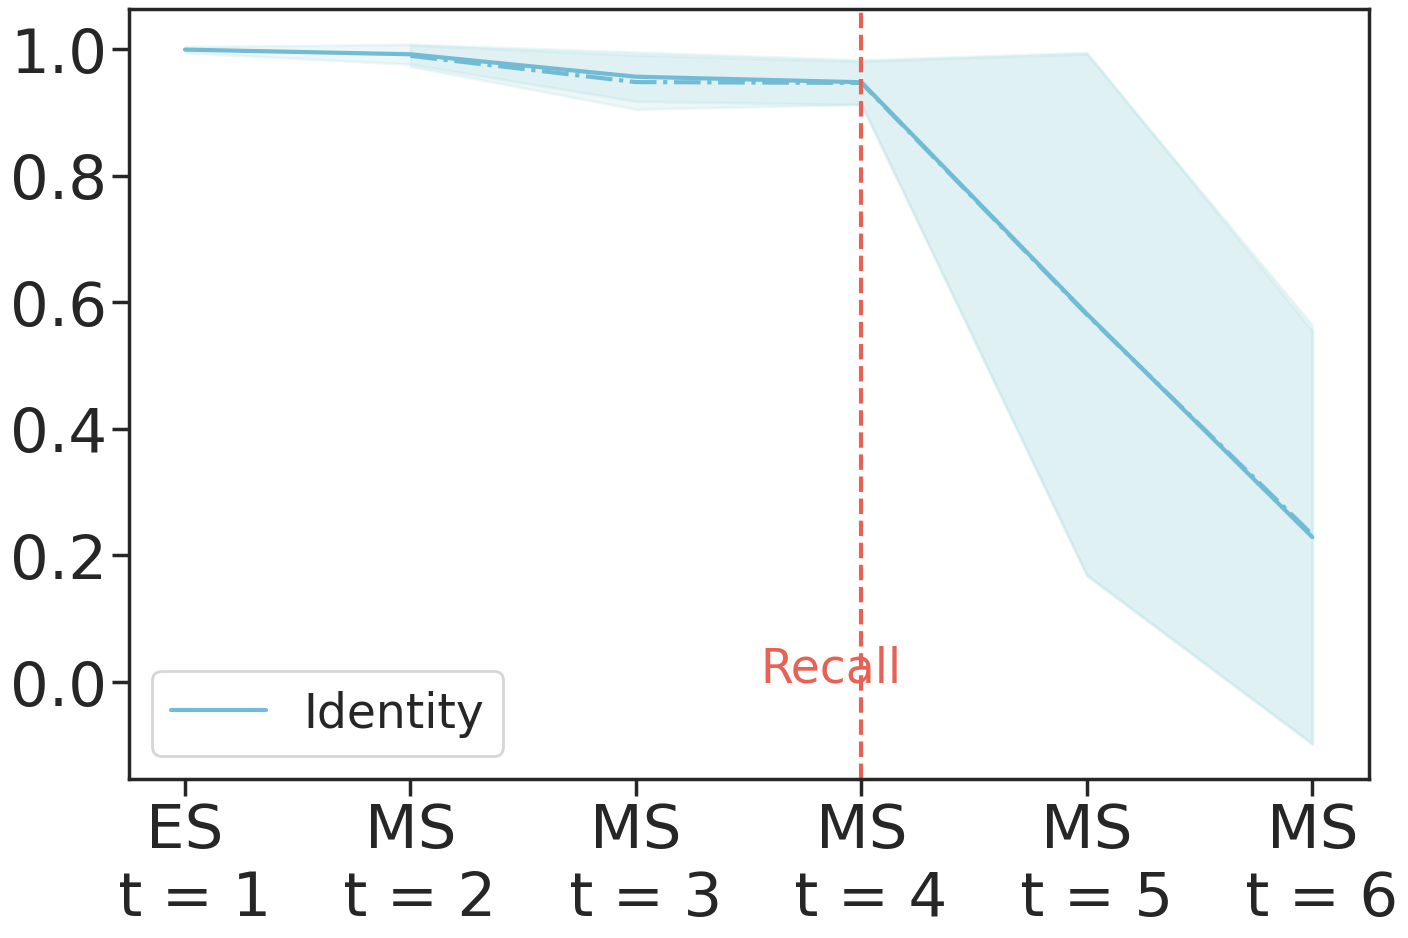

In [22]:
# Create a figure and axis
# feature_list = [0]
feature_names = ["Location", "Identity", "Category"]
plt.figure(figsize = (16,10))
for curr_task_feature in feature_list:
    curr_decoding_feature = curr_task_feature
    curr_accs_across_time = acc_across_features["tf%d_df%d"%(curr_task_feature, curr_decoding_feature)]
    aligned_accs_across_time = np.zeros_like(curr_accs_across_time)
    for t_label in range(seq_len - nback_n):
            aligned_accs_across_time[t_label,:,:6-t_label, :] = curr_accs_across_time[t_label,:,t_label:, :]

    data = [aligned_accs_across_time[:,:,t,:].reshape(-1) for t in range(seq_len)]
    # Calculate mean and standard deviation
    mean = np.array([np.mean(data[i]) for i in range(6)])
    std = np.array([np.std(data[i]) for i in range(6)])

    # Plot the mean as a red line
    plt.plot(mean, color=colors[curr_task_feature], label='%s' % feature_names[curr_task_feature])

    # Create a shaded region for the standard deviation
    plt.fill_between(np.arange(6), mean - std, mean + std, where = (mean - std) <= (mean + std), interpolate = True, color=bg_colors[curr_task_feature], alpha=0.2, )


    curr_decoding_feature = curr_task_feature
    curr_accs_across_time = transformed_accs_across_features["tf%d_df%d"%(curr_task_feature, curr_decoding_feature)]
    aligned_accs_across_time = np.zeros_like(curr_accs_across_time)
    for t_label in range(seq_len - nback_n):
            aligned_accs_across_time[t_label,:,:6-t_label, :] = curr_accs_across_time[t_label,:,t_label:, :]

    data = [aligned_accs_across_time[:,:,t,:].reshape(-1) for t in range(seq_len)]
    # Calculate mean and standard deviation
    mean = np.array([np.mean(data[i]) for i in range(6)])
    std = np.array([np.std(data[i]) for i in range(6)])

    # Plot the mean as a red line
    plt.plot(np.arange(1,6), mean[:-1], color=colors[curr_task_feature], linestyle='-.')

    # Create a shaded region for the standard deviation
    plt.fill_between(np.arange(1,6), (mean - std)[:-1], (mean + std)[:-1], where = (mean - std)[:-1] <= (mean + std)[:-1], interpolate = True, color=bg_colors[curr_task_feature], alpha=0.2, )

    
    
# Set labels and legend
# plt.xlabel('Aligned Decoding Time', fontsize = 34)
plt.xticks(np.arange(6),["ES\n t = 1", ] + ["MS\n t = %d" % i for i in range(2,7)], fontsize = 44)
# plt.yticks(fontsize = 24)
# plt.ylabel('Decoding accuracy', fontsize = 34)
# plt.title('Decoding Analysis in Memory Space', fontsize = 34)
# plt.xticks(fontsize=34)
# plt.xticks([])
plt.yticks(fontsize = 44)
plt.legend(loc="lower left", fontsize = 34)

plt.axvline(x=nback_n, color=colors[-1], linestyle='--', label='Recall')
plt.text(nback_n-0.45, 0.0, "Recall", fontsize=34, color=colors[-1])
# plt.savefig("/home/xiaoxuan/projects/WM_geometry_figures/Figures/neurips_2024/temporal_rotation/9tasks_GRU_procrustes_validation.pdf")
# plt.savefig("/home/xiaoxuan/projects/WM_geometry_figures/Figures/neurips_2024/temporal_rotation/9tasks_GRU_procrustes_validation.png")
# plt.savefig("/home/xiaoxuan/projects/multfs_triple/evaluation/Organized_analysis/results/rotation_hyperplane/Decoding_transformation.png")

In [97]:
# Now we have all Rotation matrix, decision hyperplanse across all time steps, and the corresponding dataset used to yield the results at each timestep and bootstraps
# we want to test whether R_ij == R_i(j+1) [Hypothesis 1] and R_ij == R_(i+k)(j+k) [Hypothesis 2]
# by evaluating the performances with reconstructed hyperplane

In [23]:
# Hypothesis 1: R_ij == R_i(j+1)
hyperplanes = hyperplanes_features["tf%d_df%d"%(task_feature, decoding_feature)]
Rs = Rs_features["tf%d_df%d"%(task_feature, decoding_feature)]
biases = biases_features["tf%d_df%d"%(task_feature, decoding_feature)]


cont_step_decoding_acc = {}
nb = Rs.shape[-1]
n_samples = 10

cont_step_decoding_acc["encoding 1"] = np.zeros((2,hyperplanes.shape[1],n_samples))
cont_step_decoding_acc["encoding 2"] = np.zeros((2,hyperplanes.shape[1],n_samples))
cont_step_decoding_acc["encoding 3"] = np.zeros((2,hyperplanes.shape[1],n_samples))

for i in range(3):
    for j in range(i,i+2):
        for count in range(n_samples):
            index_a1 = np.random.randint(nb)
            index_a2 = np.random.randint(nb)
            index_b1 = np.random.randint(nb)
            index_b2 = np.random.randint(nb)
            R_ij = Rs[i,j,:,:,index_a1, index_a2] # apply this rotation matrix to hyperplane at [i+k,j+k]
#             R_ij_perm = np.random.permutation(R_ij)
            curr_hyperplane = hyperplanes[i,:,j+1,index_b1, :,index_b2]
            curr_bias = biases[i, :, j+1, index_b1,index_b2]
            curr_acc = accs_across_time[i, :, j+1, index_b1,index_b2]

            a, norm_a, trans_mtx_a = std_matrix(curr_hyperplane)
            transformed_hyperplane = (np.dot(a, R_ij.T))

            for f1_index, f1 in enumerate(curr_feature_value_list):
#                 trans_clf = CustomLinearSVC(transformed_hyperplane[f1], curr_bias[f1], label_1=1000, label_2 = f1)
                trans_clf = CustomLinearSVC(a[f1_index], curr_bias[f1_index], label_1=1000, label_2 = f1)
                curr_data = X_tests["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature, i, j+1, f1,index_b1,index_b2)]
                curr_label = y_tests["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature, i, j+1, f1,index_b1,index_b2)]
                predicted_label = trans_clf.predict(curr_data)
                accuracy = accuracy_score(curr_label, predicted_label)

                cont_step_decoding_acc["encoding %d"%(i+1)][j-i,f1_index,count] = accuracy

                print("accuracy with decoder trained with data:", curr_acc[f1_index])
                print("accuracy with decoder applied with transformation:", accuracy)
                print("difference between the two decoder:", curr_acc[f1_index] - accuracy)


    

accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5714285714285714
difference between the two decoder: 0.4285714285714286
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.3888888888888889
difference between the two decoder: 0.6111111111111112
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.475
difference between the two decoder: 0.525
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5531914893617021
difference between the two decoder: 0.44680851063829785
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.4878048780487805
difference between the two decoder: 0.5121951219512195
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.6511627906976745
difference between the two decoder: 0.34883720930232553
accu

accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.475
difference between the two decoder: 0.525
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5531914893617021
difference between the two decoder: 0.44680851063829785
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.4878048780487805
difference between the two decoder: 0.5121951219512195
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.6511627906976745
difference between the two decoder: 0.34883720930232553
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.4888888888888889
difference between the two decoder: 0.5111111111111111
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5111111111111111
difference between the two decoder: 0.48888888888888893
acc

accuracy with decoder trained with data: 0.9787234042553191
accuracy with decoder applied with transformation: 0.46808510638297873
difference between the two decoder: 0.5106382978723404
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.3902439024390244
difference between the two decoder: 0.6097560975609756
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.46511627906976744
difference between the two decoder: 0.5348837209302326
accuracy with decoder trained with data: 0.9777777777777777
accuracy with decoder applied with transformation: 0.6
difference between the two decoder: 0.37777777777777777
accuracy with decoder trained with data: 0.9555555555555556
accuracy with decoder applied with transformation: 0.5333333333333333
difference between the two decoder: 0.4222222222222223
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.45454545454545453
d

accuracy with decoder trained with data: 0.9772727272727273
accuracy with decoder applied with transformation: 0.5681818181818182
difference between the two decoder: 0.40909090909090906
accuracy with decoder trained with data: 0.9761904761904762
accuracy with decoder applied with transformation: 0.5
difference between the two decoder: 0.47619047619047616
accuracy with decoder trained with data: 0.9523809523809523
accuracy with decoder applied with transformation: 0.47619047619047616
difference between the two decoder: 0.47619047619047616
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5853658536585366
difference between the two decoder: 0.41463414634146345
accuracy with decoder trained with data: 0.9
accuracy with decoder applied with transformation: 0.4
difference between the two decoder: 0.5
accuracy with decoder trained with data: 0.9047619047619048
accuracy with decoder applied with transformation: 0.5952380952380952
difference betw

accuracy with decoder trained with data: 0.9772727272727273
accuracy with decoder applied with transformation: 0.5681818181818182
difference between the two decoder: 0.40909090909090906
accuracy with decoder trained with data: 0.9761904761904762
accuracy with decoder applied with transformation: 0.5
difference between the two decoder: 0.47619047619047616
accuracy with decoder trained with data: 0.9523809523809523
accuracy with decoder applied with transformation: 0.47619047619047616
difference between the two decoder: 0.47619047619047616
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5853658536585366
difference between the two decoder: 0.41463414634146345
accuracy with decoder trained with data: 0.9
accuracy with decoder applied with transformation: 0.4
difference between the two decoder: 0.5
accuracy with decoder trained with data: 0.9047619047619048
accuracy with decoder applied with transformation: 0.5952380952380952
difference betw

accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5227272727272727
difference between the two decoder: 0.4772727272727273
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5609756097560976
difference between the two decoder: 0.4390243902439024
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.525
difference between the two decoder: 0.475
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.46511627906976744
difference between the two decoder: 0.5348837209302326
accuracy with decoder trained with data: 0.9512195121951219
accuracy with decoder applied with transformation: 0.4634146341463415
difference between the two decoder: 0.4878048780487804
accuracy with decoder trained with data: 0.9512195121951219
accuracy with decoder applied with transformation: 0.5121951219512195
difference between the two dec

accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5581395348837209
difference between the two decoder: 0.4418604651162791
accuracy with decoder trained with data: 0.8780487804878049
accuracy with decoder applied with transformation: 0.4878048780487805
difference between the two decoder: 0.3902439024390244
accuracy with decoder trained with data: 0.9512195121951219
accuracy with decoder applied with transformation: 0.5853658536585366
difference between the two decoder: 0.36585365853658536
accuracy with decoder trained with data: 0.9302325581395349
accuracy with decoder applied with transformation: 0.32558139534883723
difference between the two decoder: 0.6046511627906976
accuracy with decoder trained with data: 0.9285714285714286
accuracy with decoder applied with transformation: 0.5476190476190477
difference between the two decoder: 0.38095238095238093
accuracy with decoder trained with data: 0.9772727272727273
accuracy with decoder appli

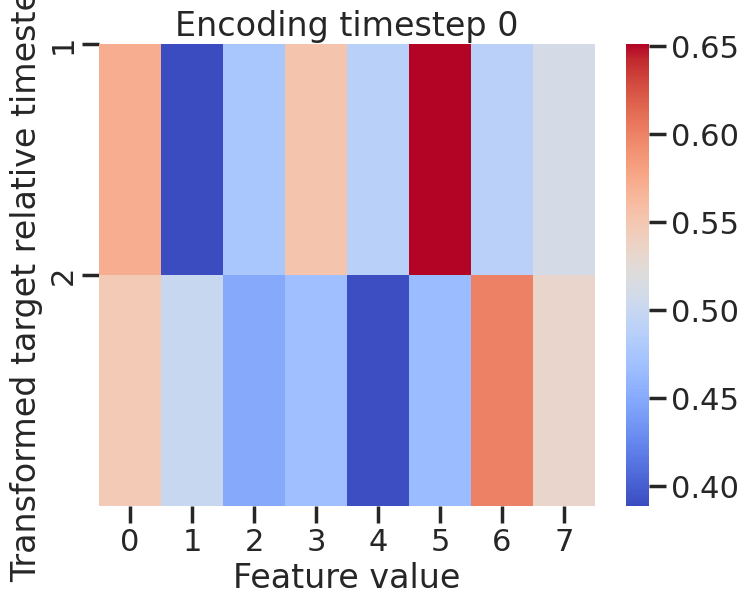

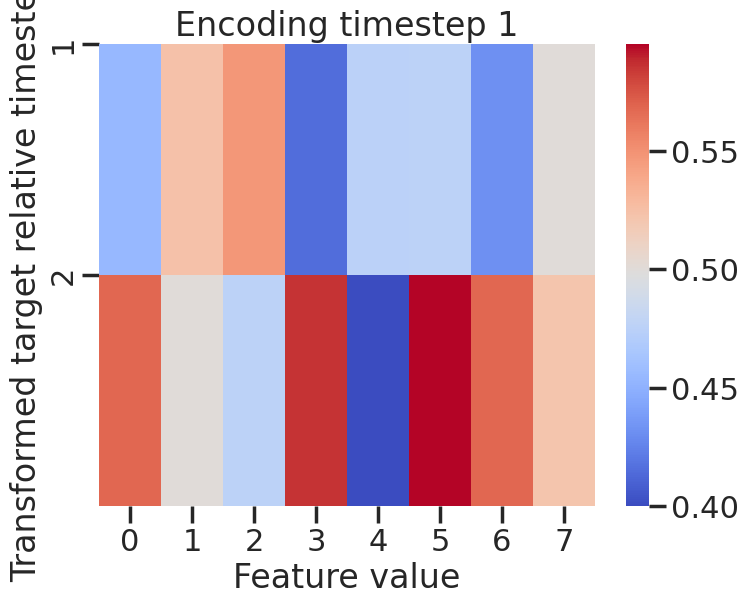

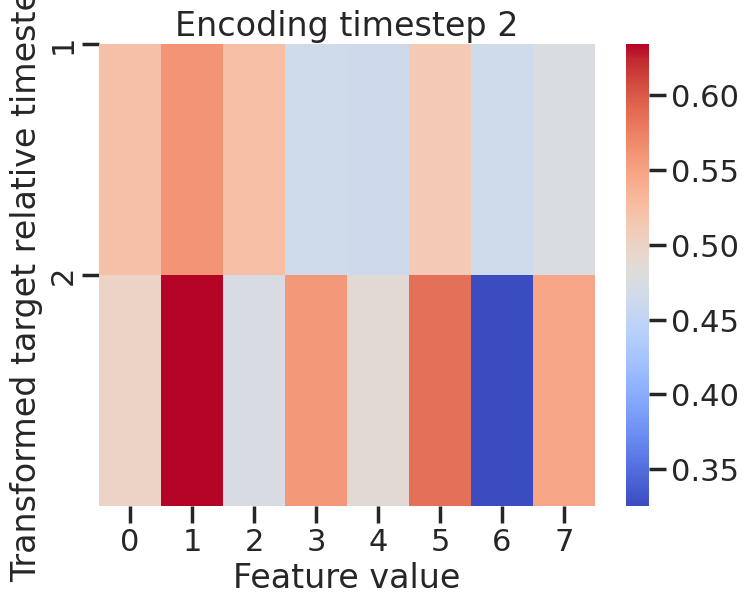

In [24]:
# plot the transformed decoding accuracy for hypothesis 1: R_ij = R_i(j+1)
for encoding in range(3):
    data = np.mean(cont_step_decoding_acc["encoding %d"%(encoding+1)],axis = -1)
    data_std = np.std(cont_step_decoding_acc["encoding %d"%(encoding+1)],axis = -1)
    
    # Create the heatmap using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=False, fmt=".1f", cmap='coolwarm', cbar=True)
    plt.yticks(np.arange(2), np.arange(1,3))

    # Add standard deviation annotations
#     for (i, j), val in np.ndenumerate(data):
#         plt.text(j + 0.5, i + 0.5, f'±{data_std[i, j]:.1f}',
#                  ha='center', va='center', color='black', fontweight='bold')

    plt.ylabel('Transformed target relative timestep')
    plt.xlabel('Feature value')
    plt.title('Encoding timestep %d' % encoding)
    plt.show()

In [25]:
# the accuracy data I should use:
hypo1_data = []
for i in range(3):
    hypo1_data.extend(cont_step_decoding_acc["encoding %d"%(i+1)].reshape(-1))


In [26]:
hyperplanes.shape

(3, 8, 6, 2, 512, 1)

In [27]:
# Hypothesis 2: R_ij == R_(i+k)(j+k)

# todo: need to check how many encoding steps to consider in n-back tasks

stepwise_decoding_acc = {}
nb = Rs.shape[-1]
n_samples = 1

stepwise_decoding_acc["step size 1"] = np.zeros((3,6,hyperplanes.shape[1],n_samples))
stepwise_decoding_acc["step size 2"] = np.zeros((3,6,hyperplanes.shape[1],n_samples))
stepwise_decoding_acc["step size 3"] = np.zeros((3,6,hyperplanes.shape[1],n_samples))
stepwise_decoding_acc["step size 4"] = np.zeros((3,6,hyperplanes.shape[1],n_samples))


for i in range(Rs.shape[0]-1):
    for k in range(1,2):
        for j in range(i,6):
            if i+k >= 3: continue
            if j+k+1 >= seq_len: continue
            for count in range(n_samples):
                index_a1 = np.random.randint(nb)
                index_a2 = np.random.randint(nb)
                index_b1 = np.random.randint(nb)
                index_b2 = np.random.randint(nb)
                R_ij = Rs[i,j,:,:,index_b1,index_b2] # apply this rotation matrix to hyperplane at [i+k,j+k]
#                 R_ij_perm = np.random.permutation(R_ij)
                
                curr_hyperplane = hyperplanes[i+k,:,j+k,index_b1, :,index_b2]
                target_hyperplane = hyperplanes[i+k, :,j+k+1, index_b1, index_b2]
                curr_bias = biases[i+k, :, j+k+1, index_b1,index_b2]
                curr_acc = accs_across_time[i+k, :, j+k, index_b1,index_b2]
                s = scaling_factors[i+k,j+k+1,index_b1,index_b2]

                a, norm_a, trans_mtx_a = std_matrix(curr_hyperplane)
                b, norm_b, trans_mtx_b = std_matrix(target_hyperplane)
#                 transformed_hyperplane = (np.dot(a, R_ij.T))
        
                
                transformed_hyperplane = (np.dot(a, R_ij.T) * s)*norm_b + trans_mtx_b

                for f1_index, f1 in enumerate(curr_feature_value_list):
                    X_train = X_trains["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature, i+k, j+k+1, f1,index_b1,index_b2)]
                    trans_clf = CustomLinearSVC(transformed_hyperplane[f1_index], curr_bias[f1_index], label_1=1000, label_2 = f1, X_train = X_train)
                    curr_data = X_trains["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature, i+k, j+k+1, f1,index_b1,index_b2)]
                    curr_label = y_trains["task_feature%d_decoding_feature%d_t_label_%d_t_activation_%d_f1_%d_bi_%d_%d"%(task_feature, decoding_feature, i+k, j+k+1, f1,index_b1,index_b2)]
                    predicted_label = trans_clf.predict(curr_data)
                    accuracy = accuracy_score(curr_label, predicted_label)

                    stepwise_decoding_acc["step size %d"%k][i,j-i,f1_index,count] = accuracy

                    print("accuracy with decoder trained with data:", curr_acc[f1_index])
                    print("accuracy with decoder applied with transformation:", accuracy)
                    print("difference between the two decoder:", curr_acc[f1_index] - accuracy)
                    
                    

accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5152284263959391
difference between the two decoder: 0.48477157360406087
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5
difference between the two decoder: 0.5
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.6042780748663101
difference between the two decoder: 0.39572192513368987
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5207756232686981
difference between the two decoder: 0.4792243767313019
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5194444444444445
difference between the two decoder: 0.4805555555555555
accuracy with decoder trained with data: 1.0
accuracy with decoder applied with transformation: 0.5052910052910053
difference between the two decoder: 0.49470899470899465
accurac

In [28]:
stepwise_decoding_acc["step size %d"%(encoding+1)].shape

(3, 6, 8, 1)

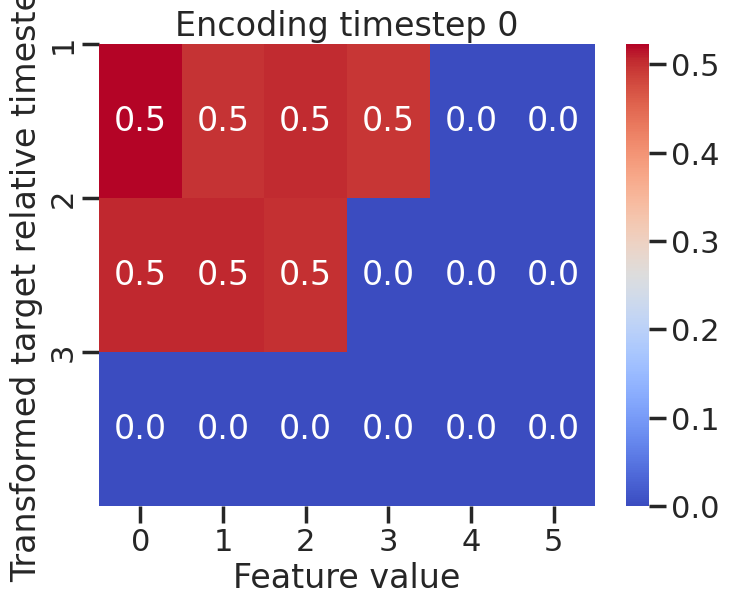

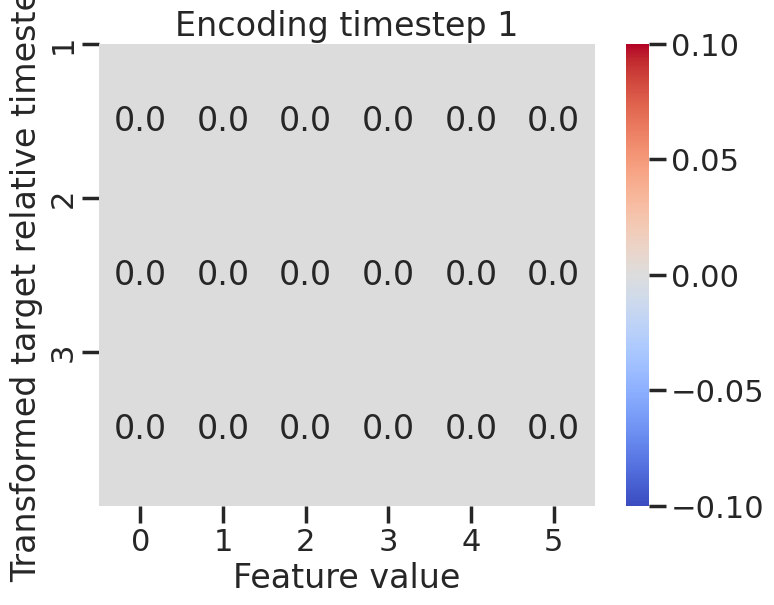

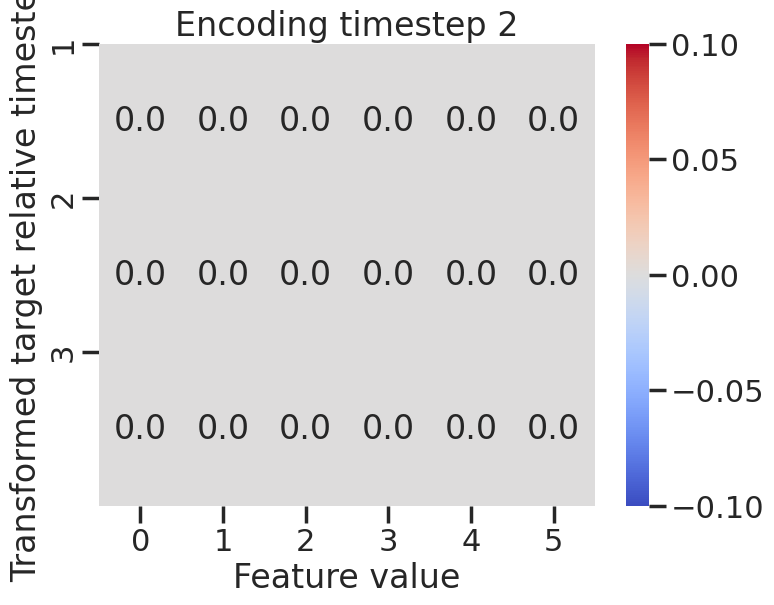

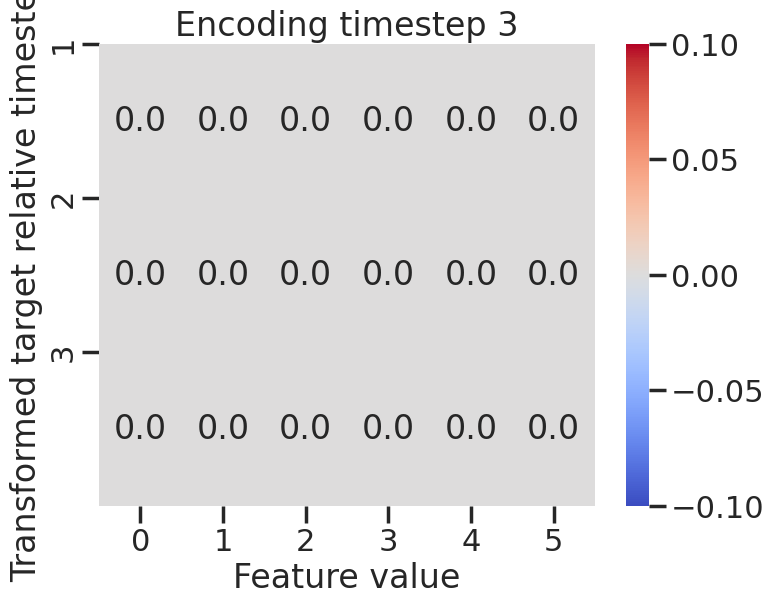

In [29]:
# plot the transformed decoding accuracy for hypothesis 2: R_ij == R_(i+k)(j+k)
for encoding in range(4):
    data = np.mean(np.mean(stepwise_decoding_acc["step size %d"%(encoding+1)],axis = -1),axis = -1)
    data_std = np.std(np.std(stepwise_decoding_acc["step size %d"%(encoding+1)],axis = -1), axis = -1)
    
    # Create the heatmap using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, fmt=".1f", cmap='coolwarm', cbar=True)
    plt.yticks(np.arange(3), np.arange(1,4))

    # Add standard deviation annotations
#     for (i, j), val in np.ndenumerate(data):
#         plt.text(j + 0.5, i + 0.5, f'±{data_std[i, j]:.1f}',
#                  ha='center', va='center', color='black', fontweight='bold')

    plt.ylabel('Transformed target relative timestep')
    plt.xlabel('Feature value')
    plt.title('Encoding timestep %d' % encoding)
    plt.show()

In [30]:
# the accuracy data I should use:
hypo2_data = []
for i in range(4):
    temp = stepwise_decoding_acc["step size %d"%(i+1)].reshape(-1)
    hypo2_data.extend(temp[temp!=0])


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$R_{i+k,j+k}$ vs. $R_{i,j+1}$: Mann-Whitney-Wilcoxon test two-sided, P_val:7.019e-01 U_stat=1.386e+04


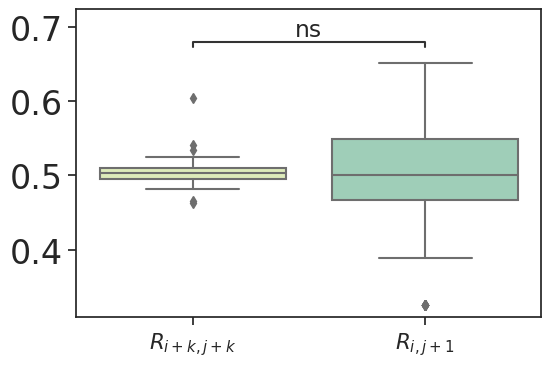

In [31]:
# plot the comparison between two decoding accuracies with stats test
from statannotations.Annotator import Annotator
df = {}
df["Category"] = []
df["Accuracy"] = []

df["Accuracy"].extend(hypo2_data)
df["Category"].extend([r'$R_{i+k,j+k}$']*len(hypo2_data))

df["Accuracy"].extend(hypo1_data)
df["Category"].extend([r'$R_{i,j+1}$']*len(hypo1_data))

df = pd.DataFrame(df) 

def get_log_ax(orient="v"):
    if orient == "v":
        figsize = (6, 4)
        set_scale = "set_yscale"
    else:
        figsize = (10, 8)
        set_scale = "set_xscale"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.patch.set_alpha(1)
    getattr(ax, set_scale)("linear")
    return ax

def label_plot_for_states(ax):
#     plt.title("Goal amounts per project State", y=1.06)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Category", labelpad=20)
    
    
pairs = [
    (r'$R_{i+k,j+k}$', r'$R_{i,j+1}$'),
]

states_palette = sns.color_palette("YlGnBu", n_colors=5)
states_order = [r'$R_{i+k,j+k}$',r'$R_{i,j+1}$']

state_plot_params = {
    'data': df,
    'x': 'Category',
    'y': 'Accuracy',
    'order': states_order,
    'palette': states_palette
}

with sns.plotting_context('notebook', font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **state_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **state_plot_params)
    annotator.configure(test='Mann-Whitney').apply_and_annotate()

    # Label and show
    label_plot_for_states(ax)
    plt.xlabel("")
    plt.ylabel("")
    plt.yticks(fontsize = 24)
    
